In [1]:
import utils.fetcher_utils as fetcher
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import utils.preprocess_util as preproc


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Get the data from the IMDb dataFrame
imdb_df = fetcher.aquireIMDbDataFrame()
imdb_df.head()

Reading data from ../resources\movie_metadata.csv


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
drop_columns = ['movie_imdb_link','aspect_ratio', 'plot_keywords']

imdb_df_filtered = imdb_df.drop(columns=drop_columns)
imdb_df_filtered = imdb_df_filtered.dropna(subset='title_year')


In [5]:
imdb_X_train_filtered = imdb_df_filtered[sorted(imdb_df_filtered.columns)]

In [6]:
imdb_df_filtered = imdb_df_filtered[(imdb_df_filtered['gross']>1_000) & 
                                    (imdb_df_filtered['budget']>1_000) & 
                                    (imdb_df_filtered['country'] == 'USA') &
                                    (imdb_df['title_year']>1994)].drop(columns='country').reset_index(drop=True)
imdb_df_filtered

C:\Users\fagui\AppData\Local\Temp\ipykernel_4876\3164738777.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imdb_df_filtered = imdb_df_filtered[(imdb_df_filtered['gross']>1_000) &


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,3054.0,English,PG-13,237000000.0,2009.0,936.0,7.9,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,1238.0,English,PG-13,300000000.0,2007.0,5000.0,7.1,0
2,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,2701.0,English,PG-13,250000000.0,2012.0,23000.0,8.5,164000
3,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,738.0,English,PG-13,263700000.0,2012.0,632.0,6.6,24000
4,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,1902.0,English,PG-13,258000000.0,2007.0,11000.0,6.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,Color,Jay Duplass,51.0,85.0,157.0,10.0,Katie Aselton,830.0,192467.0,Comedy|Drama|Romance,Mark Duplass,The Puffy Chair,4067,1064,Bari Hyman,0.0,71.0,English,R,15000.0,2005.0,224.0,6.6,297
2658,Color,Daryl Wein,22.0,88.0,38.0,211.0,Heather Burns,331.0,76382.0,Romance,Zoe Lister-Jones,Breaking Upwards,1194,1546,Ebon Moss-Bachrach,2.0,8.0,English,NaN,15000.0,2009.0,212.0,6.2,324
2659,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Drama|Sci-Fi|Thriller,Shane Carruth,Primer,72639,368,Casey Gooden,0.0,371.0,English,PG-13,7000.0,2004.0,45.0,7.0,19000
2660,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,Kerry Bishé,Newlyweds,1338,690,Daniella Pineda,1.0,14.0,English,Not Rated,9000.0,2011.0,205.0,6.4,413


In [7]:
# imdb_df_filtered.dropna(inplace=True)

In [8]:
X = imdb_df_filtered.drop(columns=['imdb_score'])
y = imdb_df_filtered['imdb_score']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
counter = 1

for df in [X_train, X_test]:

       df = preproc._director_frequence(df)
       df = preproc._process_genres(df)

       content_rating_replaced_df = preproc._bucket_contentRatings(df)

       if counter == 1:
              print('1')
              encoder = OneHotEncoder(sparse_output=False)  
              content_rating_encoded = encoder.fit_transform(content_rating_replaced_df[["rating_bin"]])
              content_rating_encoded = pd.DataFrame(content_rating_encoded, columns=encoder.get_feature_names_out(["rating_bin"]))
              content_rating_encoded

       else:
              print('2')
              content_rating_encoded = encoder.transform(content_rating_replaced_df[["rating_bin"]])
              content_rating_encoded = pd.DataFrame(content_rating_encoded, columns=encoder.get_feature_names_out(["rating_bin"]))
              content_rating_encoded

        

       df = pd.concat([df.reset_index(drop=True), content_rating_encoded], axis=1)
       # df.drop('content_rating', axis=1, inplace=True)

       df = preproc._actor_frequency(df)

       df['total_facebook_likes'] = df['actor_1_facebook_likes'] + df['actor_2_facebook_likes'] + df['actor_3_facebook_likes']

       drop_columns = ['actor_1_facebook_likes', 'actor_2_facebook_likes','actor_3_facebook_likes','color','language','movie_title']
       df = df.drop(columns=drop_columns)


       columns_to_standardize = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
              'gross', 'num_voted_users', 'cast_total_facebook_likes',
              'facenumber_in_poster', 'num_user_for_reviews', 'budget', 'title_year',
              'movie_facebook_likes', 'director_frequency', 'total_actor_frequency',
              'total_facebook_likes']


       scaler = StandardScaler()

       # Fit the scaler to the training data
       scaler.fit(df[columns_to_standardize])

       # Scale the training features
       scaled_features = scaler.transform(df[columns_to_standardize])

       # Create a DataFrame with the scaled features
       scaled_df = pd.DataFrame(scaled_features, columns=columns_to_standardize)

       df = pd.concat([df.drop(columns=columns_to_standardize), scaled_df], axis=1)

       df = df.fillna(-1)

       if counter == 1:
              X_train = df[sorted(df.columns)]
       else:
              X_test = df[sorted(df.columns)]
       
       counter += 1

       print(sorted(df.columns))

       display(df)

1
['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Romance', 'Sci-Fi', 'Thriller', 'budget', 'cast_total_facebook_likes', 'director_facebook_likes', 'director_frequency', 'duration', 'facenumber_in_poster', 'gross', 'movie_facebook_likes', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'other_genre', 'rating_bin_PG', 'rating_bin_PG-13', 'rating_bin_R', 'rating_bin_other', 'title_year', 'total_actor_frequency', 'total_facebook_likes']


,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Fantasy,Family,Sci-Fi,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,movie_facebook_likes,director_frequency,total_actor_frequency,total_facebook_likes
0,1,0,1,1,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.740219,0.034898,-0.197964,0.124021,-0.015569,0.596603,0.697754,-0.434683,-0.400034,1.051259,-0.447893,-0.455005,0.799898,0.609189
1,1,1,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,-0.212205,-0.667190,-0.222854,-0.271692,-0.508665,-0.519603,-0.193224,-0.576536,-0.076404,1.051259,-0.447893,0.422473,-1.007637,-0.493163
2,0,0,1,1,1,1,0,0,0,1,0,0.0,1.0,0.0,0.0,0.957031,0.837285,-0.097111,-0.412858,-0.081119,-0.509557,0.697754,0.020223,-0.076404,1.224487,1.431921,-0.016266,-1.007637,-0.487836
3,0,0,1,1,0,0,0,0,0,1,1,0.0,1.0,0.0,0.0,0.027837,0.436091,-0.007896,-0.605947,-0.320748,0.213192,-0.638714,-0.520284,-0.378459,1.570943,0.032989,-0.455005,0.076884,0.233070
4,1,0,1,1,0,0,1,0,0,1,0,0.0,0.0,1.0,0.0,3.210325,0.536390,-0.254532,0.123737,2.236538,1.066672,-0.638714,0.802856,-0.292158,1.051259,2.830853,-0.893744,1.794042,1.103028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,1,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,-0.452246,0.385942,-0.206045,-0.690427,-0.545842,0.359647,0.252265,-0.645016,-0.507911,1.051259,0.120423,0.422473,0.167260,0.362427
1992,0,1,0,0,0,0,0,0,1,0,0,1.0,0.0,0.0,0.0,-0.390300,-1.018233,-0.250653,-0.105090,-0.503175,1.764787,0.252265,-0.534958,-0.184281,0.531574,-0.447893,-0.455005,0.619144,1.748871
1993,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,-0.429016,0.135197,-0.083535,-0.617675,-0.521423,0.298715,0.697754,-0.319734,-0.184281,-0.854251,-0.447893,1.299952,0.348014,0.334452
1994,1,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,-0.204461,0.987732,-0.254532,-0.272561,-0.409320,-0.330300,0.697754,-0.195002,-0.292158,-1.027479,-0.447893,-0.893744,-0.736507,-0.415414


2
['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'budget', 'cast_total_facebook_likes', 'director_facebook_likes', 'director_frequency', 'duration', 'facenumber_in_poster', 'gross', 'movie_facebook_likes', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'other_genre', 'rating_bin_PG', 'rating_bin_PG-13', 'rating_bin_R', 'rating_bin_other', 'title_year', 'total_actor_frequency', 'total_facebook_likes']


,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Sci-Fi,Fantasy,Mystery,Family,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,movie_facebook_likes,director_frequency,total_actor_frequency,total_facebook_likes
0,0,1,0,0,0,1,0,0,0,0,1,0,1.0,0.0,0.0,0.0,-1.100776,-0.901159,-0.247234,-0.539577,-0.637780,-0.514853,-0.758910,-0.638655,-0.703685,-0.808303,-0.406310,0.268116,-0.147687,-0.624998
1,0,1,0,1,0,0,1,1,0,0,1,1,1.0,0.0,0.0,0.0,-0.341301,-1.056403,-0.247234,-0.481484,-0.565801,-0.634597,-0.758910,-0.542297,2.473800,0.912150,-0.422360,0.268116,-0.386425,-0.635134
2,0,1,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0,0.0,-0.589130,-0.849411,-0.250017,-0.535257,-0.597477,-0.402865,-0.278074,-0.605041,-0.174104,0.740104,-0.422360,1.087223,-0.386425,-0.449657
3,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,-0.189406,0.444286,-0.248780,-0.586553,-0.313383,0.188983,-0.278074,-0.589355,-0.519483,0.912150,-0.422360,-0.550991,-0.863899,0.073797
4,0,1,0,1,1,0,1,1,0,0,1,0,1.0,0.0,0.0,0.0,-0.956875,-0.435428,-0.252491,-0.455280,-0.605452,-0.565866,1.164435,-0.694676,-0.381332,-0.292167,-0.415136,-0.550991,-0.863899,-0.595248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0,0,0,0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,2.864480,-0.435428,-0.124761,-0.576805,0.015767,-0.734857,-0.758910,0.620714,-0.933938,1.428285,1.524359,-0.550991,-1.102637,-0.717670
662,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,-1.028825,-1.159898,-0.252801,-0.769526,-0.651399,-0.776159,-0.758910,-0.627450,-0.968476,-0.980348,-0.422360,-0.550991,-1.102637,-0.736758
663,0,0,0,0,0,0,1,0,1,0,0,0,0.0,1.0,0.0,0.0,2.672613,4.014890,-0.254965,2.886937,2.277389,-0.224730,2.126108,1.337792,4.200694,1.256240,3.168255,0.268116,-0.863899,-0.317296
664,0,0,1,0,0,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,1.185642,-0.901159,-0.254965,0.131525,0.322272,0.059150,-0.758910,2.039184,0.125224,0.396014,-0.162797,2.725437,0.091050,0.074455


In [11]:
X_train

,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Romance,Sci-Fi,Thriller,budget,cast_total_facebook_likes,director_facebook_likes,director_frequency,duration,facenumber_in_poster,gross,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,title_year,total_actor_frequency,total_facebook_likes
0,1,0,0,1,1,0,0,0,0,1,-0.400034,0.596603,-0.197964,-0.455005,0.034898,0.697754,0.124021,-0.447893,0.740219,-0.434683,-0.015569,0,0.0,0.0,1.0,0.0,1.051259,0.799898,0.609189
1,0,0,1,0,1,0,0,0,0,0,-0.076404,-0.519603,-0.222854,0.422473,-0.667190,-0.193224,-0.271692,-0.447893,-0.212205,-0.576536,-0.508665,0,0.0,1.0,0.0,0.0,1.051259,-1.007637,-0.493163
2,1,1,0,0,0,0,0,1,1,1,-0.076404,-0.509557,-0.097111,-0.016266,0.837285,0.697754,-0.412858,1.431921,0.957031,0.020223,-0.081119,0,0.0,1.0,0.0,0.0,1.224487,-1.007637,-0.487836
3,1,0,0,0,0,0,0,0,1,1,-0.378459,0.213192,-0.007896,-0.455005,0.436091,-0.638714,-0.605947,0.032989,0.027837,-0.520284,-0.320748,1,0.0,1.0,0.0,0.0,1.570943,0.076884,0.233070
4,1,0,0,1,1,0,0,0,1,1,-0.292158,1.066672,-0.254532,-0.893744,0.536390,-0.638714,0.123737,2.830853,3.210325,0.802856,2.236538,0,0.0,0.0,1.0,0.0,1.051259,1.794042,1.103028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0,0,0,0,1,0,0,0,0,0,-0.507911,0.359647,-0.206045,0.422473,0.385942,0.252265,-0.690427,0.120423,-0.452246,-0.645016,-0.545842,1,1.0,0.0,0.0,0.0,1.051259,0.167260,0.362427
1992,0,0,1,0,0,1,0,0,0,0,-0.184281,1.764787,-0.250653,-0.455005,-1.018233,0.252265,-0.105090,-0.447893,-0.390300,-0.534958,-0.503175,0,1.0,0.0,0.0,0.0,0.531574,0.619144,1.748871
1993,0,0,0,0,1,0,0,0,0,0,-0.184281,0.298715,-0.083535,1.299952,0.135197,0.697754,-0.617675,-0.447893,-0.429016,-0.319734,-0.521423,0,0.0,0.0,1.0,0.0,-0.854251,0.348014,0.334452
1994,0,0,1,0,1,0,0,1,0,0,-0.292158,-0.330300,-0.254532,-0.893744,0.987732,0.697754,-0.272561,-0.447893,-0.204461,-0.195002,-0.409320,0,0.0,1.0,0.0,0.0,-1.027479,-0.736507,-0.415414


In [12]:
X_test =  X_test.drop(columns='Mystery')
X_test

,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Romance,Sci-Fi,Thriller,budget,cast_total_facebook_likes,director_facebook_likes,director_frequency,duration,facenumber_in_poster,gross,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,title_year,total_actor_frequency,total_facebook_likes
0,0,0,1,1,0,1,0,0,0,0,-0.703685,-0.514853,-0.247234,0.268116,-0.901159,-0.758910,-0.539577,-0.406310,-1.100776,-0.638655,-0.637780,0,1.0,0.0,0.0,0.0,-0.808303,-0.147687,-0.624998
1,1,1,1,0,0,1,0,0,1,0,2.473800,-0.634597,-0.247234,0.268116,-1.056403,-0.758910,-0.481484,-0.422360,-0.341301,-0.542297,-0.565801,1,1.0,0.0,0.0,0.0,0.912150,-0.386425,-0.635134
2,0,0,1,0,0,1,0,0,0,0,-0.174104,-0.402865,-0.250017,1.087223,-0.849411,-0.278074,-0.535257,-0.422360,-0.589130,-0.605041,-0.597477,0,1.0,0.0,0.0,0.0,0.740104,-0.386425,-0.449657
3,0,0,1,0,0,0,0,1,0,0,-0.519483,0.188983,-0.248780,-0.550991,0.444286,-0.278074,-0.586553,-0.422360,-0.189406,-0.589355,-0.313383,0,0.0,0.0,1.0,0.0,0.912150,-0.863899,0.073797
4,1,1,1,0,0,1,0,1,1,0,-0.381332,-0.565866,-0.252491,-0.550991,-0.435428,1.164435,-0.455280,-0.415136,-0.956875,-0.694676,-0.605452,0,1.0,0.0,0.0,0.0,-0.292167,-0.863899,-0.595248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0,0,0,0,0,0,0,0,0,0,-0.933938,-0.734857,-0.124761,-0.550991,-0.435428,-0.758910,-0.576805,1.524359,2.864480,0.620714,0.015767,1,0.0,0.0,1.0,0.0,1.428285,-1.102637,-0.717670
662,0,0,0,0,1,0,0,0,0,0,-0.968476,-0.776159,-0.252801,-0.550991,-1.159898,-0.758910,-0.769526,-0.422360,-1.028825,-0.627450,-0.651399,1,0.0,0.0,1.0,0.0,-0.980348,-1.102637,-0.736758
663,0,1,0,0,0,0,1,0,0,0,4.200694,-0.224730,-0.254965,0.268116,4.014890,2.126108,2.886937,3.168255,2.672613,1.337792,2.277389,0,0.0,1.0,0.0,0.0,1.256240,-0.863899,-0.317296
664,0,0,0,0,0,0,0,0,1,1,0.125224,0.059150,-0.254965,2.725437,-0.901159,-0.758910,0.131525,-0.162797,1.185642,2.039184,0.322272,0,0.0,0.0,1.0,0.0,0.396014,0.091050,0.074455


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1996 entries, 0 to 1995
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Action                     1996 non-null   int32  
 1   Adventure                  1996 non-null   int32  
 2   Comedy                     1996 non-null   int32  
 3   Crime                      1996 non-null   int32  
 4   Drama                      1996 non-null   int32  
 5   Family                     1996 non-null   int32  
 6   Fantasy                    1996 non-null   int32  
 7   Romance                    1996 non-null   int32  
 8   Sci-Fi                     1996 non-null   int32  
 9   Thriller                   1996 non-null   int32  
 10  budget                     1996 non-null   float64
 11  cast_total_facebook_likes  1996 non-null   float64
 12  director_facebook_likes    1996 non-null   float64
 13  director_frequency         1996 non-null   float

In [14]:
corr_test = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
corr_test.corr()['imdb_score'].sort_values(ascending=False)

imdb_score                   1.000000
num_voted_users              0.496501
num_critic_for_reviews       0.407940
duration                     0.371264
num_user_for_reviews         0.331248
movie_facebook_likes         0.315034
Drama                        0.303447
gross                        0.252130
total_actor_frequency        0.217105
director_facebook_likes      0.205060
director_frequency           0.174732
rating_bin_R                 0.146697
total_facebook_likes         0.145696
cast_total_facebook_likes    0.145594
budget                       0.117709
other_genre                  0.069777
Adventure                    0.042657
title_year                   0.032544
rating_bin_other             0.031119
Crime                        0.026096
Sci-Fi                      -0.025920
Thriller                    -0.029111
Romance                     -0.031092
Action                      -0.055286
Fantasy                     -0.056448
Family                      -0.057590
facenumber_i

In [15]:
# Create a function to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [16]:
calc_vif(X_train).sort_values("VIF", ascending=False)

,variables,VIF
11,cast_total_facebook_likes,214.093193
28,total_facebook_likes,208.380575
24,rating_bin_R,4.945406
23,rating_bin_PG-13,4.710800
18,num_critic_for_reviews,4.515743
20,num_voted_users,4.255636
22,rating_bin_PG,3.886030
10,budget,3.332946
16,gross,3.319805
19,num_user_for_reviews,3.302217


In [17]:
X_train_filtered = X_train.drop(columns=['cast_total_facebook_likes', 'rating_bin_R'])
X_test_filtered = X_test.drop(columns=['cast_total_facebook_likes', 'rating_bin_R'])
calc_vif(X_train_filtered).sort_values("VIF", ascending=False)

,variables,VIF
17,num_critic_for_reviews,4.502885
19,num_voted_users,4.222442
5,Family,3.600157
18,num_user_for_reviews,3.271027
10,budget,3.257700
15,gross,3.147043
21,rating_bin_PG,3.115616
16,movie_facebook_likes,2.447113
2,Comedy,2.140335
1,Adventure,2.127057


In [18]:
import statsmodels.api as sm

# Use the statsmodels package to create and fit a linear regression
lr = sm.OLS(y_train.reset_index(drop=True), X_train_filtered).fit()

In [19]:
# Create a variable to hold the p-values of all columns sorted in ascending order
p_values = lr.pvalues.sort_values(ascending=False)
p_values

director_frequency          6.137429e-01
facenumber_in_poster        6.052886e-01
total_actor_frequency       5.510248e-01
title_year                  5.436412e-01
director_facebook_likes     1.675533e-01
num_user_for_reviews        1.608623e-01
movie_facebook_likes        6.880415e-02
Family                      2.963998e-02
gross                       2.888718e-02
total_facebook_likes        1.856999e-02
duration                    3.934944e-04
Fantasy                     3.932270e-06
num_critic_for_reviews      1.924324e-06
Sci-Fi                      2.265968e-07
num_voted_users             3.944270e-08
budget                      1.808554e-14
Romance                     1.728457e-14
Adventure                   2.369182e-16
Crime                       6.136942e-18
rating_bin_other            8.233411e-19
rating_bin_PG               1.163437e-20
Action                      4.635419e-23
Thriller                    2.624658e-29
rating_bin_PG-13            2.242850e-34
other_genre     

In [20]:
# Use loc to filter to columns with p-values below 0.05
select_cols = p_values.loc[p_values < 0.05]

# Show the index of the results
select_cols.index

Index(['Family', 'gross', 'total_facebook_likes', 'duration', 'Fantasy',
       'num_critic_for_reviews', 'Sci-Fi', 'num_voted_users', 'budget',
       'Romance', 'Adventure', 'Crime', 'rating_bin_other', 'rating_bin_PG',
       'Action', 'Thriller', 'rating_bin_PG-13', 'other_genre', 'Comedy',
       'Drama'],
      dtype='object')

In [21]:
len(select_cols.index)

20

In [22]:
X_train_filtered=X_train_filtered[select_cols.index]
X_train_filtered

,Family,gross,total_facebook_likes,duration,Fantasy,num_critic_for_reviews,Sci-Fi,num_voted_users,budget,Romance,Adventure,Crime,rating_bin_other,rating_bin_PG,Action,Thriller,rating_bin_PG-13,other_genre,Comedy,Drama
0,0,0.124021,0.609189,0.034898,0,0.740219,0,-0.015569,-0.400034,0,0,1,0.0,0.0,1,1,0.0,0,0,1
1,0,-0.271692,-0.493163,-0.667190,0,-0.212205,0,-0.508665,-0.076404,0,0,0,0.0,0.0,0,0,1.0,0,1,1
2,0,-0.412858,-0.487836,0.837285,0,0.957031,1,-0.081119,-0.076404,1,1,0,0.0,0.0,1,1,1.0,0,0,0
3,0,-0.605947,0.233070,0.436091,0,0.027837,1,-0.320748,-0.378459,0,0,0,0.0,0.0,1,1,1.0,1,0,0
4,0,0.123737,1.103028,0.536390,0,3.210325,1,2.236538,-0.292158,0,0,1,0.0,0.0,1,1,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0,-0.690427,0.362427,0.385942,0,-0.452246,0,-0.545842,-0.507911,0,0,0,0.0,1.0,0,0,0.0,1,0,1
1992,1,-0.105090,1.748871,-1.018233,0,-0.390300,0,-0.503175,-0.184281,0,0,0,0.0,1.0,0,0,0.0,0,1,0
1993,0,-0.617675,0.334452,0.135197,0,-0.429016,0,-0.521423,-0.184281,0,0,0,0.0,0.0,0,0,0.0,0,0,1
1994,0,-0.272561,-0.415414,0.987732,0,-0.204461,0,-0.409320,-0.292158,1,0,0,0.0,0.0,0,0,1.0,0,1,1


In [23]:
X_test_filtered=X_test_filtered[select_cols.index]
X_test_filtered

,Family,gross,total_facebook_likes,duration,Fantasy,num_critic_for_reviews,Sci-Fi,num_voted_users,budget,Romance,Adventure,Crime,rating_bin_other,rating_bin_PG,Action,Thriller,rating_bin_PG-13,other_genre,Comedy,Drama
0,1,-0.539577,-0.624998,-0.901159,0,-1.100776,0,-0.637780,-0.703685,0,0,1,0.0,1.0,0,0,0.0,0,1,0
1,1,-0.481484,-0.635134,-1.056403,0,-0.341301,1,-0.565801,2.473800,0,1,0,0.0,1.0,1,0,0.0,1,1,0
2,1,-0.535257,-0.449657,-0.849411,0,-0.589130,0,-0.597477,-0.174104,0,0,0,0.0,1.0,0,0,0.0,0,1,0
3,0,-0.586553,0.073797,0.444286,0,-0.189406,0,-0.313383,-0.519483,1,0,0,0.0,0.0,0,0,0.0,0,1,0
4,1,-0.455280,-0.595248,-0.435428,0,-0.956875,1,-0.605452,-0.381332,1,1,0,0.0,1.0,1,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0,-0.576805,-0.717670,-0.435428,0,2.864480,0,0.015767,-0.933938,0,0,0,0.0,0.0,0,0,0.0,1,0,0
662,0,-0.769526,-0.736758,-1.159898,0,-1.028825,0,-0.651399,-0.968476,0,0,0,0.0,0.0,0,0,0.0,1,0,1
663,0,2.886937,-0.317296,4.014890,1,2.672613,0,2.277389,4.200694,0,1,0,0.0,0.0,0,0,1.0,0,0,0
664,0,0.131525,0.074455,-0.901159,0,1.185642,1,0.322272,0.125224,0,0,0,0.0,0.0,0,1,0.0,0,0,0


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_filtered, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_filtered)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [25]:
print(mse)
print(r2)

0.591869251022959
0.4420007508793221


In [ ]:
from sklearn.linear_model import Lasso

# Create and train a lasso regression model
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train, y_train)

# Create predictions with the model
y_predicted_lasso = lasso_model.predict(X_test)

print(mean_squared_error(y_test, y_predicted_lasso))
# print(r2_score(y_test, y_predicted_lasso))

1.0607544052942466
-5.2225441055542277e-05


In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
model_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])
model_cv = model_cv.fit(X_train, y_train)

In [31]:
# Display the alpha of the best model
model_cv.alpha_

1.0

In [33]:
# Create a model using the best alpha
model2 = Ridge(alpha=model_cv.alpha_)

# Train the model
model2.fit(X_train, y_train)

# Create predictions and calculate the mean squared error
y_predicted2 = model2.predict(X_test)
mean_squared_error(y_test, y_predicted2)
print(r2_score(y_test, y_predicted2))

0.47749878354507924


# Label Encoder

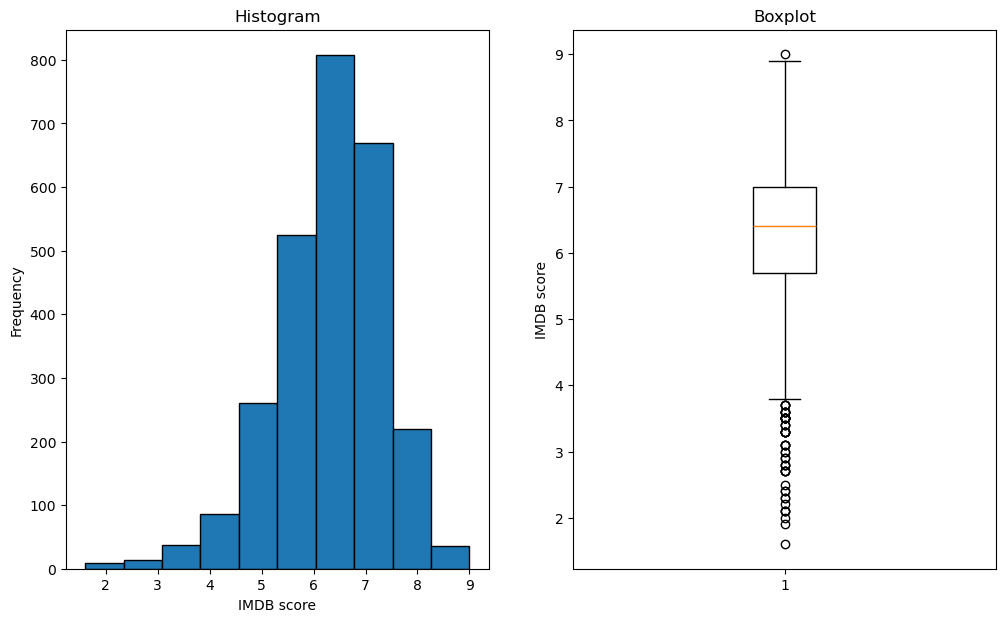

In [27]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot the histogram on the first subplot
ax1.hist(imdb_df_filtered['imdb_score'], bins=10, edgecolor='black')
ax1.set_title('Histogram')
ax1.set_xlabel('IMDB score')
ax1.set_ylabel('Frequency')

# Plot the boxplot on the second subplot
ax2.boxplot(imdb_df_filtered['imdb_score'])
ax2.set_title('Boxplot')
ax2.set_ylabel('IMDB score')

# Show the figure
plt.show()

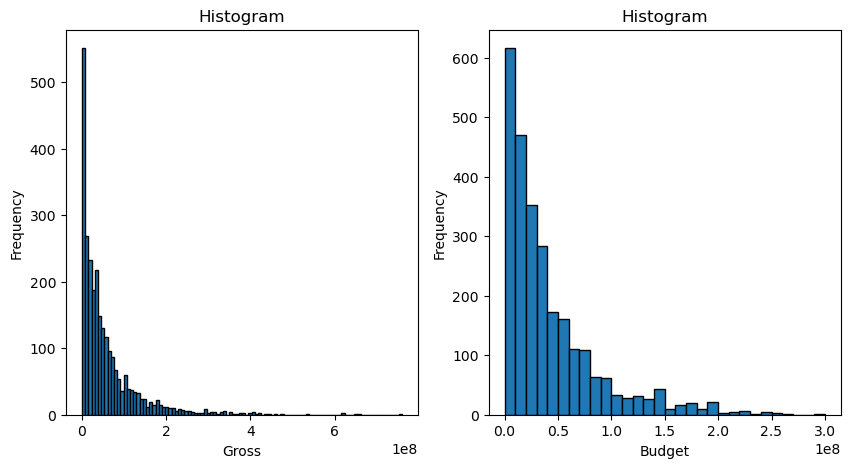

In [28]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram on the first subplot
ax1.hist(imdb_df_filtered['gross'], bins=100, edgecolor='black')
ax1.set_title('Histogram')
ax1.set_xlabel('Gross')
ax1.set_ylabel('Frequency')

# Plot the histogram on the first subplot
ax2.hist(imdb_df_filtered['budget'], bins=30, edgecolor='black')
ax2.set_title('Histogram')
ax2.set_xlabel('Budget')
ax2.set_ylabel('Frequency')

# Show the figure
plt.show()